In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from pandas import Series
from sklearn.metrics import mean_squared_error
from datetime import datetime
from ipywidgets import IntProgress

/home/glissa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [2]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [3]:
from tqdm import tqdm_notebook

### GLOBAL VARIABLES

In [4]:
INPUT_PATH = '../../../data/processed'
INPUT_FILE_NAME = 'dataproc_v005'

NRUN = 2
DAYS_PRED = 28
METRIC = 'rmse'

### FUNCTIONS

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### LOAD DATASET

In [6]:
data = pd.read_pickle(f'{INPUT_PATH}/{INPUT_FILE_NAME}.pkl')

In [7]:
train = data[data.part == 'train'] # select only train data

In [8]:
features = ['id','date', 'demand_smoothed']

In [9]:
train = train[features]

In [10]:
train.sort_values(['id','date'], inplace=True, ascending=True)

In [11]:
idx_vector = train.id.unique()

In [12]:
train_vector = []
STEP=703
init = 0
for n in tqdm_notebook(range(1,train.id.nunique()+1)):
    end = STEP*n
    ts = train.iloc[init:end, -2:]
    ts.columns = ['ds', 'y']
    train_vector.append(ts)
    init+=STEP
    

In [13]:
del data

In [14]:
calendar = pd.read_csv(f'../../../data/raw/calendar.csv')
holidays = calendar[calendar.event_name_1.isnull()!=True][['date','event_name_1']]
holidays.columns = ['ds','holiday']

## TRAIN MODEL

In [15]:
cfg_prophet = dict()

In [16]:
cfg_prophet['yearly_seasonality'] = False
cfg_prophet['daily_seasonality'] = False
cfg_prophet['weekly_seasonality'] = False
cfg_prophet['holidays'] = holidays
cfg_prophet['seasonality_prior_scale'] = 0.1

# If you plot your data and you see a trend that keeps on growing with no real saturation insight (or if your 
# domain expert tells you there is no saturation to worry about) you will set this parameter to "linear".
# If you plot it and you see a curve that is showing promise of saturation (or if you are working with 
# values that you know must saturate, for example CPU usage) then you will set it to "logistic".
cfg_prophet['growth'] = 'linear'

####  Id = 300

In [22]:
idx = 3500
train = train_vector[idx]



In [28]:
m = Prophet(**cfg_prophet).add_seasonality(
    name='monthly', period=30.5, fourier_order=12).add_seasonality(
    name='weekly', period=7, fourier_order=10).add_seasonality(
    name='yearly', period=365.25, fourier_order=12).add_seasonality(
    name='quarterly', period=365.25/4, fourier_order=5, prior_scale=0.1)

#.add_seasonality(
#name='monthly', period=30.5, fourier_order=12).add_seasonality(
#name='daily', period=1, fourier_order=15).add_seasonality(
#name='weekly', period=7, fourier_order=20).add_seasonality(
#name='yearly', period=365.25, fourier_order=20).add_seasonality(
#name='quarterly', period=365.25/4, fourier_order=5, prior_scale=15)

# show all warnings and fail on exception if debugging
with catch_warnings():
    filterwarnings("ignore")

    m.fit(train)
    future = m.make_future_dataframe(periods=DAYS_PRED)

    forecast = m.predict(future)

In [30]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chanukah End,Chanukah End_lower,Chanukah End_upper,Christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-05-23,0.546024,0.359241,0.518601,0.546024,0.546024,0.0,0.0,0.0,0.0,...,-0.031708,-0.031708,-0.031708,-0.055728,-0.055728,-0.055728,0.0,0.0,0.0,0.438529
1,2014-05-24,0.545159,0.422004,0.589272,0.545159,0.545159,0.0,0.0,0.0,0.0,...,0.070853,0.070853,0.070853,-0.055856,-0.055856,-0.055856,0.0,0.0,0.0,0.510189
2,2014-05-25,0.544293,0.494032,0.657791,0.544293,0.544293,0.0,0.0,0.0,0.0,...,0.148193,0.148193,0.148193,-0.056692,-0.056692,-0.056692,0.0,0.0,0.0,0.576435
3,2014-05-26,0.543427,0.373114,0.543383,0.543427,0.543427,0.0,0.0,0.0,0.0,...,0.019212,0.019212,0.019212,-0.058228,-0.058228,-0.058228,0.0,0.0,0.0,0.458407
4,2014-05-27,0.542562,0.306265,0.474713,0.542562,0.542562,0.0,0.0,0.0,0.0,...,-0.037836,-0.037836,-0.037836,-0.060429,-0.060429,-0.060429,0.0,0.0,0.0,0.389365


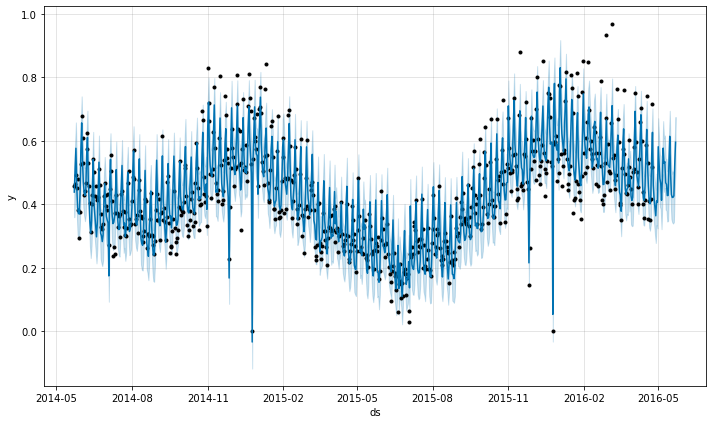

In [29]:
fig1 = m.plot(forecast)

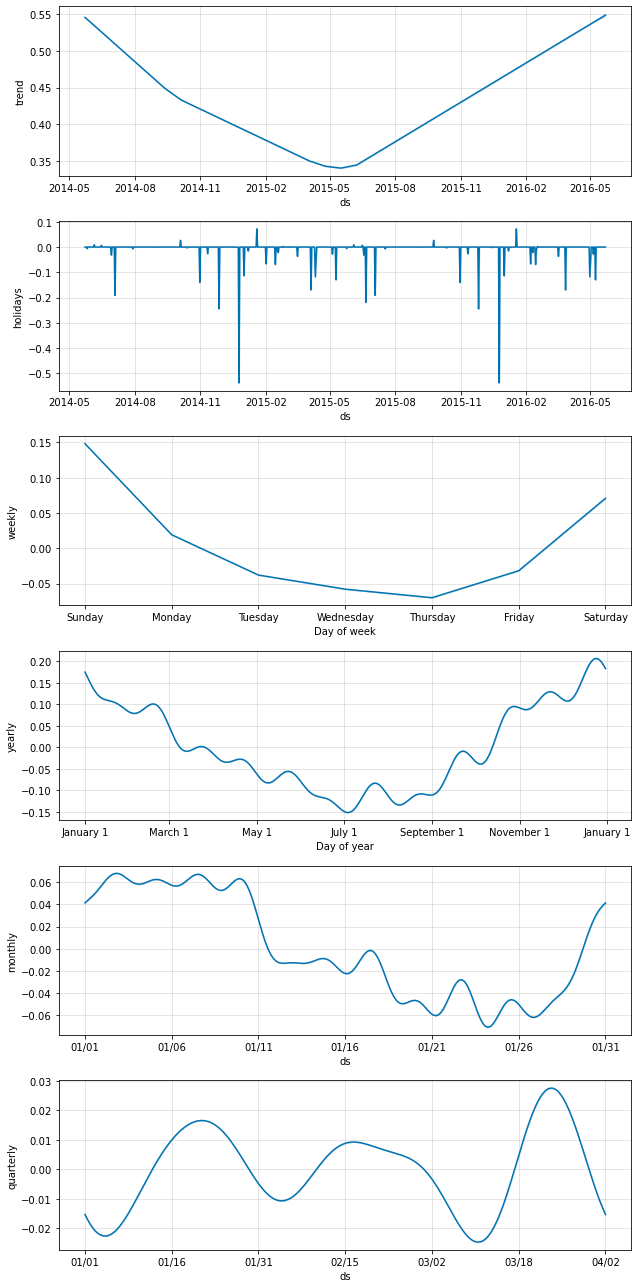

In [20]:
fig2 = m.plot_components(forecast)

In [21]:
print("RMSE: ", rmse(train.iloc[-DAYS_PRED:,-1], forecast.iloc[-DAYS_PRED:,-1]))

RMSE:  0.08377876180398523


####  Id = 0

In [22]:
idx = 0
train = train_vector[idx]



In [23]:
m = Prophet(**cfg_prophet).add_seasonality(
    name='monthly', period=30.5, fourier_order=12).add_seasonality(
    name='weekly', period=7, fourier_order=10).add_seasonality(
    name='yearly', period=365.25, fourier_order=12).add_seasonality(
    name='quarterly', period=365.25/4, fourier_order=5, prior_scale=15)



# show all warnings and fail on exception if debugging
with catch_warnings():
    filterwarnings("ignore")

    m.fit(train)
    future = m.make_future_dataframe(periods=DAYS_PRED, include_history=True)

    forecast = m.predict(future)

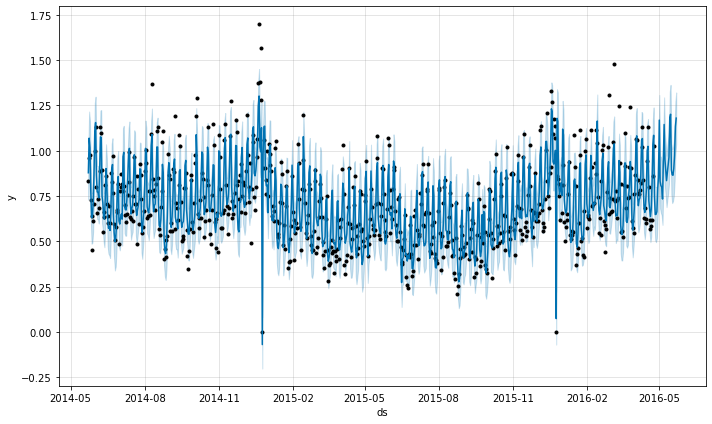

In [24]:
fig1 = m.plot(forecast)

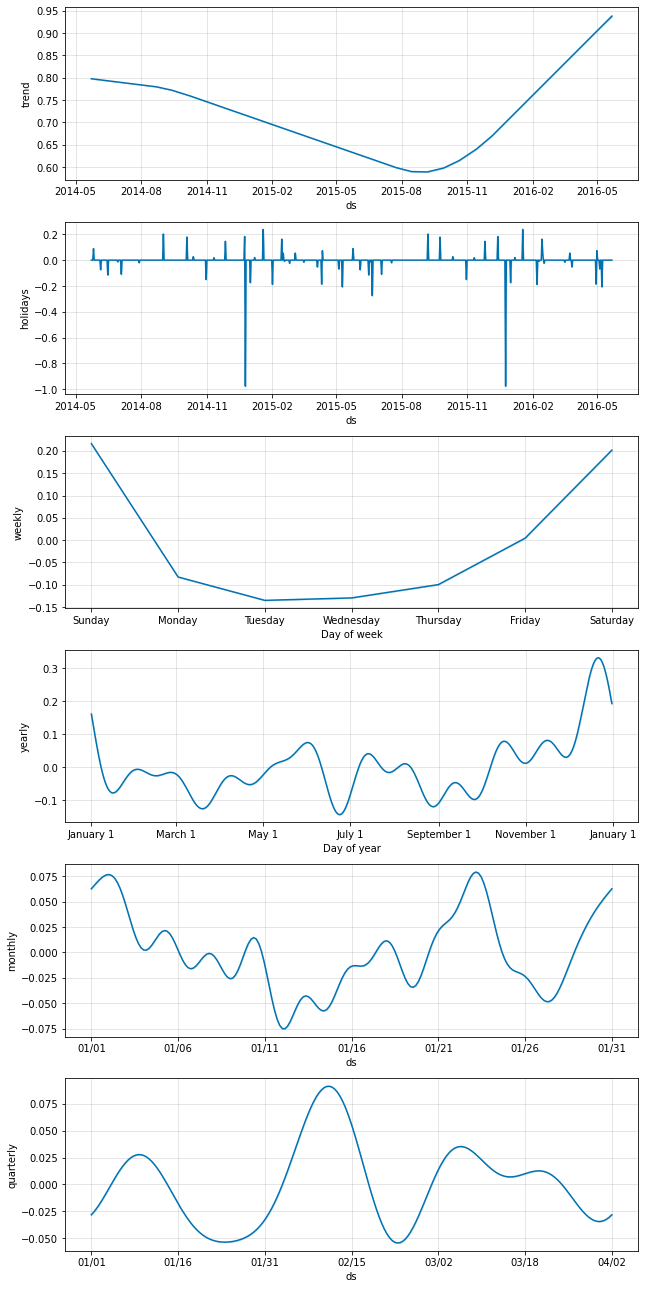

In [25]:
fig2 = m.plot_components(forecast)

In [26]:
print("RMSE: ", rmse(train.iloc[-DAYS_PRED:,-1], forecast.iloc[-DAYS_PRED:,-1]))

RMSE:  0.18669894849666652


####  Id = 30000

In [27]:
idx = 30000
train = train_vector[idx]



In [28]:
m = Prophet(**cfg_prophet).add_seasonality(
    name='monthly', period=30.5, fourier_order=12).add_seasonality(
    name='weekly', period=7, fourier_order=12).add_seasonality(
    name='yearly', period=365.25, fourier_order=12).add_seasonality(
    name='quarterly', period=365.25/4, fourier_order=5, prior_scale=15)



# show all warnings and fail on exception if debugging
with catch_warnings():
    filterwarnings("ignore")

    m.fit(train)
    future = m.make_future_dataframe(periods=DAYS_PRED)

    forecast = m.predict(future)

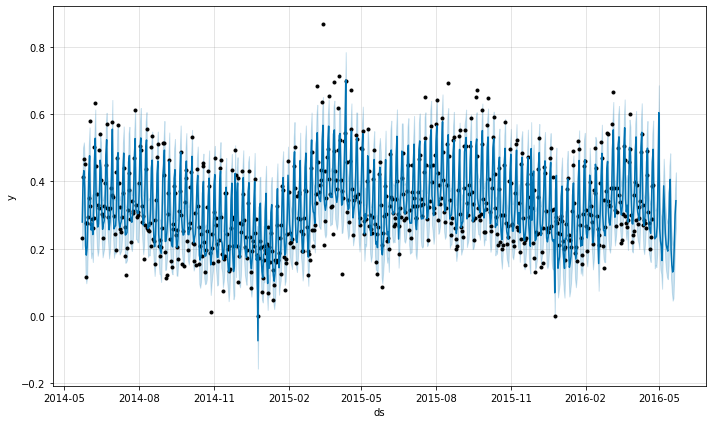

In [29]:
fig1 = m.plot(forecast)

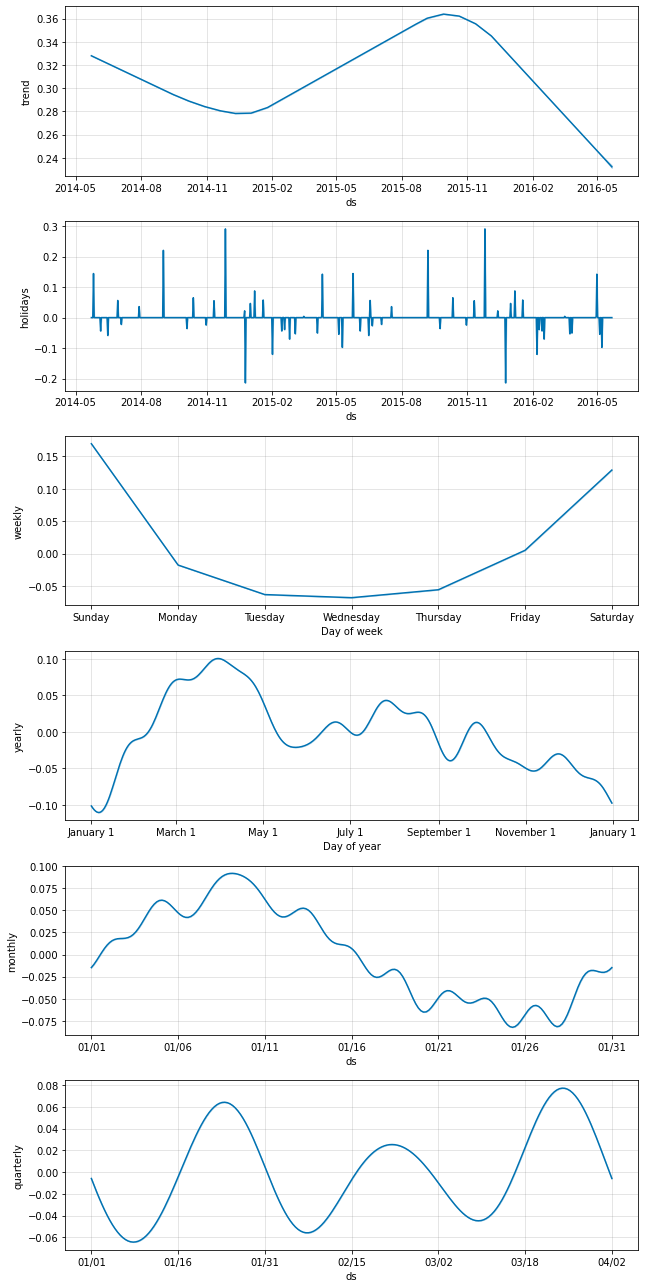

In [30]:
fig2 = m.plot_components(forecast)

In [31]:
print("RMSE: ", rmse(train.iloc[-DAYS_PRED:,-1], forecast.iloc[-DAYS_PRED:,-1]))

RMSE:  0.1065292325422362
